In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install boto3
!pip install -q shap
!pip install pyyaml

     |████████████████████████████████| 17.0 MB 8.1 MB/s 
     |████████████████████████████████| 181 kB 55.5 MB/s 
     |████████████████████████████████| 79 kB 8.8 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 146 kB 43.1 MB/s 
     |████████████████████████████████| 209 kB 52.4 MB/s 
     |████████████████████████████████| 78 kB 8.4 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 59 kB 7.6 MB/s 
     |████████████████████████████████| 745 kB 8.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 7.6 MB/s 
     |████████████████████████████████| 9.1 MB 50.7 MB/s 
     |████████████████████████████████| 79 kB 9.5 MB/s 
     |████████████████████████████████| 140 kB 71.7 MB/s 
  Attempting uninstall: urllib3
    Found exist

In [ ]:
import os
import warnings
import sys
import pandas as pd
import numpy as np
import xgboost

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import logging
import boto3

import shap

import matplotlib.pyplot as plt

from shap.plots import *
from mlflow.utils.file_utils import TempDir

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

In [ ]:
import os
#yaml file on the upper level to protect rest of the data
os.chdir('/content/drive/My Drive/')

In [ ]:
with open('/content/drive/My Drive/conf/mlconfig.yml') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
def preprocessing(data):
  #this is simply a trick to remove the last column which tends to be always NaN for some reason
  data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
  #print(data)
  data.drop(columns='End-Date', inplace=True)

  data["Price_Change_rel"] = pd.to_numeric(data["Price_Change_rel"], downcast="float")
  data["Schädling-TotalFrequency"] = pd.to_numeric(data["Schädling-TotalFrequency"], downcast="float")
  data["Schädling-MeanSentiment"] = pd.to_numeric(data["Schädling-MeanSentiment"], downcast="float")
  data["GeneralWoodDamage-TotalFrequency"] = pd.to_numeric(data["GeneralWoodDamage-TotalFrequency"], downcast="float")
  data["GeneralWoodDamage-MeanSentiment"] = pd.to_numeric(data["GeneralWoodDamage-MeanSentiment"], downcast="float")
  data["Wetter-TotalFrequency"] = pd.to_numeric(data["Wetter-TotalFrequency"], downcast="float")
  data["Wetter-MeanSentiment"] = pd.to_numeric(data["Wetter-MeanSentiment"], downcast="float")
  data["Folgeindustrie-TotalFrequency"] = pd.to_numeric(data["Folgeindustrie-TotalFrequency"], downcast="float")
  data["Folgeindustrie-MeanSentiment"] = pd.to_numeric(data["Folgeindustrie-MeanSentiment"], downcast="float")
  data["rolling-Schädling-MeanSentiment"] = pd.to_numeric(data["rolling-Schädling-MeanSentiment"], downcast="float")
  data["rolling-GeneralWoodDamage-MeanSentiment"] = pd.to_numeric(data["rolling-GeneralWoodDamage-MeanSentiment"],
                                                                    downcast="float")
  data["rolling-Wetter-MeanSentiment"] = pd.to_numeric(data["rolling-Wetter-MeanSentiment"], downcast="float")
  data["rolling-Folgeindustrie-MeanSentiment"] = pd.to_numeric(data["rolling-Folgeindustrie-MeanSentiment"],
                                                                 downcast="float")

  data.drop(columns='BEDAT', inplace=True)
  #removes last empty column
  #data.drop(columns=data.columns[-1], axis=1, inplace=True)

  X = data.drop(['Price_Change_rel'],axis=1).values
  y = data['Price_Change_rel']

  train_pct_index = int(0.8 * len(X))
  X_train, X_test = X[:train_pct_index], X[train_pct_index:]
  y_train, y_test = y[:train_pct_index], y[train_pct_index:]
  return X_train, X_test, y_train, y_test
  #return train_test_split(X, y, test_size=0.2)

In [ ]:
def eval_metrics(actual, pred):
  rmse = np.sqrt(mean_squared_error(actual, pred))
  mae = mean_absolute_error(actual, pred)
  r2 = r2_score(actual, pred)
  return rmse, mae, r2

In [ ]:
def mlflow_start():
  remote_server_uri = data['remote_server_uri']
  user_name = data['username']
  password = data['password']
  mlflow.set_tracking_uri(remote_server_uri)
  os.environ['MLFLOW_TRACKING_USERNAME'] = user_name
  os.environ['MLFLOW_TRACKING_PASSWORD'] = password
  os.environ['MLFLOW_S3_ENDPOINT_URL'] = data['s3_enpoint_url']
  os.environ['AWS_ACCESS_KEY_ID'] = data['aws_access_key_id']
  os.environ['AWS_SECRET_ACCESS_KEY'] = data['aws_secret_access_key']

mlflow_start()

In [ ]:
# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive/')

Mounted at /content/drive/


        BEDAT  Price_Change_rel  End-Date  Schädling-TotalFrequency  \
0  2019-01-01          0.000428  1/1/2019                       0.0   
1  2019-01-02          0.000428  1/2/2019                       1.0   
2  2019-01-03          0.000428  1/3/2019                       3.0   
3  2019-01-04          0.000428  1/4/2019                       3.0   
4  2019-01-05          0.000428  1/5/2019                       0.0   

   Schädling-MeanSentiment  GeneralWoodDamage-TotalFrequency  \
0                     0.00                               1.0   
1                    -0.06                               1.0   
2                    -0.97                               0.0   
3                     0.01                               1.0   
4                     0.00                               0.0   

   GeneralWoodDamage-MeanSentiment  Wetter-TotalFrequency  \
0                             0.00                    0.0   
1                            -0.41                    1.0   
2    

Permutation explainer: 668it [01:32,  6.38it/s]
Registered model 'XGBoost' already exists. Creating a new version of this model...
2022/09/02 06:50:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGBoost, version 29
Created version '29' of model 'XGBoost'.


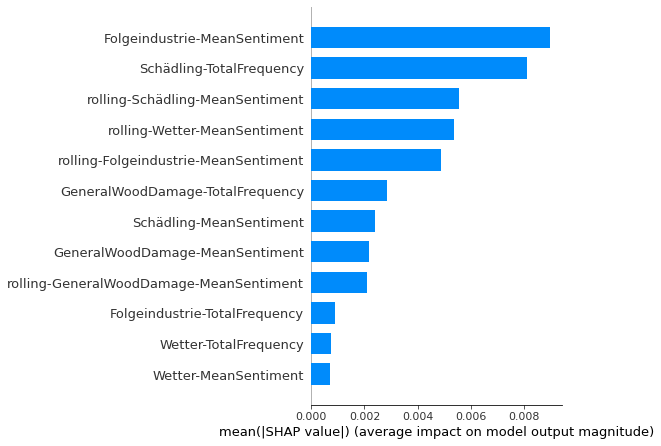

In [ ]:
def main():
  warnings.filterwarnings("ignore")
  np.random.seed(40)

  #data = []

  try:
    #ds = 'softwoodshort'
    #ds = 'hardwoodshort'
    #ds = 'nadelholz'
    ds = 'rohpapier'

    dataset_drive = data['dataset_drive']
    experiment_name = data['experiment_name']
    dataset = dataset_drive + ds + ".csv"
    with open(dataset) as f:
      data = pd.read_csv(f, delimiter=',')
      print(data.head())

      X_train, X_test, y_train, y_test = preprocessing(data)

      n_estimators = 100 #int(sys.argv[1]) if len(sys.argv) > 1 else 1000
      max_features = 9 #int(sys.argv[2]) if len(sys.argv) > 2 else 9
      max_depth = 5 #int(sys.argv[3]) if len(sys.argv) > 3 else 5

      mlflow.end_run()
      mlflow.set_experiment(experiment_name)

      with mlflow.start_run(run_name='xgboost_rohpapier') as run:
          np.seterr(invalid='ignore')

          xgbregs = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100)
          model = xgbregs.fit(X_train, y_train)
          y_pred = model.predict(X_test)

          (rmse, mae, r2) = eval_metrics(y_test, y_pred)
          print("XGBoost model (n_estimators=%d, max_features=%d, max_depth=%d):" % (n_estimators, max_features, max_depth))
          print("  RMSE: %s" % rmse)
          print("  MAE: %s" % mae)
          print("  R2: %s" % r2)

          #TODO mlflow flavor
          mlflow.log_param("ds", ds)
          mlflow.log_param("n_estimators", n_estimators)
          mlflow.log_param("max_features", max_features)
          mlflow.log_param("max_depth", max_depth)
          metrics = {"rmse": float(rmse), "r2": float(r2), "mae": float(mae)} 
          #mlflow.log_metric("rmse", rmse)
          #mlflow.log_metric("r2", r2)
          #mlflow.log_metric("mae", mae)
          mlflow.log_metrics(metrics)

          featurenames = ["Schädling-TotalFrequency","Schädling-MeanSentiment","GeneralWoodDamage-TotalFrequency","GeneralWoodDamage-MeanSentiment","Wetter-TotalFrequency","Wetter-MeanSentiment","Folgeindustrie-TotalFrequency","Folgeindustrie-MeanSentiment","rolling-Schädling-MeanSentiment","rolling-GeneralWoodDamage-MeanSentiment","rolling-Wetter-MeanSentiment","rolling-Folgeindustrie-MeanSentiment"]

          print(featurenames[1])
          print(featurenames[3])

          # Fits the explainer
          explainer = shap.Explainer(model.predict, X_train, feature_names = featurenames)
          # Calculates the SHAP values - It takes some time
          shap_values = explainer(X_train)
          #shap_values = explainer.shap_values(X_test)
          
          #shap.plots.bar(shap_values, max_display=12)
          #shap.plots.bar(shap_values[0], max_display=12)
          #shap.plots.waterfall(shap_values[0], max_display=12)

          shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=12, show=False)
          import matplotlib.pyplot as plt
          plt.savefig("summary_plot.png")

          mlflow.log_artifact('summary_plot.png')

          tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

          if tracking_url_type_store != "file":
            mlflow.xgboost.log_model(xgbregs, "model", registered_model_name="XGBoost")
            # Log a dictionary as a YAML file in a subdirectory of the run's root artifact directory
            mlflow.log_dict(metrics, "dir/data.json")
          else:
            mlflow.sklearn.log_model(xgbregs, "model")

  except Exception as e:
    logger.exception(
        "Unable to download training & test CSV, check your internet connection. Error: %s", e
    )


main()